# Importing Neccessary Libraries

In [1]:
import time
start = time.time()

from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
import numpy as np
# import torch
# from torchvision import transforms
# import torchstain

from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential
from keras.applications import ResNet50, InceptionV3, InceptionResNetV2, EfficientNetV2S
from keras.preprocessing import image
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from keras.models import load_model
from sklearn.cluster import KMeans
import numpy as np


2022-08-11 04:18:25.372677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-11 04:18:25.372702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Assigning Parameters

##### InceptionV3: 299, 2048
##### ResNet50: 224, 2048
##### InceptionResNetV2: 299, 1536
##### EfficientNetV2S: 384, 1280

In [34]:
IMG_SIZE = 384
NUMBER_OF_FEATURES = 1280

# Loading Dataset Images with Pre-Processing

In [35]:
# target = cv2.cvtColor(cv2.imread("./data/target.png"), cv2.COLOR_BGR2RGB)
# to_transform = cv2.cvtColor(cv2.imread("./data/source.png"), cv2.COLOR_BGR2RGB)

# T = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x*255)
# ])

# torch_normalizer = torchstain.MacenkoNormalizer(backend='torch')
# torch_normalizer.fit(T(target))

# t_to_transform = T(to_transform)
# norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)

In [36]:
# Method for perform K-Means clustering segmentation on the input image
def segmentImg(image_path):
    img = cv2.imread(image_path)

    # EXTRACT TUMOR START
    p=1;
    kernel = np.ones((7,7),np.float32)/25
    img1 = cv2.filter2D(img,-1,kernel)

    ## Bilateral Filter for Edge Enhancement
    img3 = cv2.bilateralFilter(img1,9,75,75)

    ## RGB to Gray conversion
    GRAY_Img = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)

    roi1=GRAY_Img
    if p==1:
        roi = roi1.reshape((roi1.shape[0] * roi1.shape[1], 1))

    ## K-Means clustering
    imgkmeans = KMeans(n_clusters=3, random_state=1)
    imgkmeans.fit(roi)
    label_values=imgkmeans.labels_
    Label_reshped = np.reshape(label_values,(roi1.shape[0] ,roi1.shape[1]))

    segmentregions=roi1

    rows,cols = roi1.shape;
    # Thresholding for segmentation
    for i in range(0,rows):
        for j in range(0,cols):
            pixl=Label_reshped[i,j];
            if pixl==0:
                segmentregions[i,j]=0;
            else:
                segmentregions[i,j]=255;

    # Thresholding for segmentation
    NewImage = img.copy();
    extractedregions=NewImage;

    for k in range(0,rows):
        for l in range(0,cols):
            pixl1=segmentregions[k,l];
            if pixl1==0:
                extractedregions[k,l]=NewImage[k,l];
            else:
                extractedregions[k,l]=0;
    
    # CONTOURING
    img_gray = cv2.cvtColor(extractedregions, cv2.COLOR_BGR2GRAY)      # convert to greyscale
    ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY) # apply binary thresholding

    # Detect the contours on the binary image using cv2.CHAIN_APPROX_NONE
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                        
    # Draw contours on the original image
    image_copy = img.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 0, 0), thickness=3, lineType=cv2.LINE_AA)
                
    return image_copy

In [37]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    '''
    1) Convert to RGB (but this was not done in code below)
    2) Resize image to 299 pixels (using OpenCV2)
    3) Convert to Array (using numpy)
    '''
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".tif":  # Transfer tif images to an array IMG
            img = read(PATH) # Read and convert to RGB
                    
            # Torchstain Normalizer
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # t_to_transform = T(img)
            # norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)
            # img = cv2.resize(np.array(norm, dtype = 'uint8'), (RESIZE, RESIZE))  

            img = segmentImg(PATH)                 # segment image
            img = cv2.resize(img, (RESIZE,RESIZE)) # resize image
            IMG.append(np.array(img))              # convert image to numpy array & append to array of images
        
    return IMG

# Loading the dataset for each class
benign_data = np.array(Dataset_loader('Photos/Benign',IMG_SIZE))
insitu_data = np.array(Dataset_loader('Photos/InSitu',IMG_SIZE))
invasive_data = np.array(Dataset_loader('Photos/Invasive',IMG_SIZE))
normal_data = np.array(Dataset_loader('Photos/Normal',IMG_SIZE))

100%|██████████| 101/101 [18:15<00:00, 10.84s/it]


# Creating Labels for the dataset
##### 4 Labels: Benign, InSitu, Invasive, Normal

In [38]:
# Create labels
benign_label = np.zeros(len(benign_data))
insitu_label = np.ones(len(insitu_data))
invasive_label = np.full(len(invasive_data), 2)
normal_label = np.full(len(normal_data), 3)

# Merge data
X = np.concatenate((benign_data, insitu_data, invasive_data, normal_data), axis = 0)
Y = np.concatenate((benign_label, insitu_label, invasive_label, normal_label), axis = 0)

# Shuffle data
s = np.arange(X.shape[0])
np.random.shuffle(s)
X = X[s]
Y = Y[s]
    
# To categorical
# Y = to_categorical(Y, num_classes= 4)

# Feature Extraction using CNN (Transfer Learning)

In [39]:
# base_model = InceptionV3(weights='imagenet')
# base_model = ResNet50(weights='imagenet')
# base_model = InceptionResNetV2(weights='imagenet')
base_model = EfficientNetV2S(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

features_array = np.zeros((400,NUMBER_OF_FEATURES))

for i in range(len(X)):
    x = np.expand_dims(X[i], axis=0) 
    # x = tf.keras.applications.inception_v3.preprocess_input(x)
    # x = tf.keras.applications.resnet50.preprocess_input(x)
    # x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
    
    features = model.predict(x)
    features = features.reshape(NUMBER_OF_FEATURES,)
    features_array[i,:] = features
    

1/1 [==============================] - 0s 98ms/step


In [40]:
df = pd.DataFrame(features_array)
df['label'] = Y

## Split data into train and test

In [41]:
from sklearn.model_selection import train_test_split
X = df.drop(['label'], axis=1)
Y = df.label

'''
70% training
15% validation
15% testing

Validation to avoid overfitting.

Model is robust = when changing the training, testing & validation, the performance doesn't change that much.
'''

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, 
    train_size=0.7, 
    random_state=0
    )

# x_val, x_test, y_val, y_test = train_test_split(
#     X_remainder, Y_remainder, 
#     train_size=0.5, 
#     random_state=11
#     )

## SVM with K-Fold

In [43]:
clf = SVC()
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

print("Accuracy on test data: %.2f" %accuracy_score(y_test, preds))

Accuracy on test data: 0.68


In [44]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = x_train, y = y_train, cv = 10)
print(accuracies)
print("Average accuracy for K-Fold CV: %.4f" %accuracies.mean())
# accuracies.std()

[0.60714286 0.67857143 0.57142857 0.85714286 0.75       0.78571429
 0.71428571 0.67857143 0.85714286 0.75      ]
Average accuracy for K-Fold CV: 0.7250


# Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

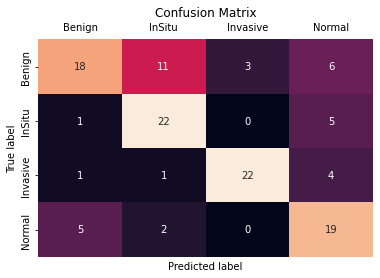

In [45]:
labels = ['Benign', 'InSitu', 'Invasive', 'Normal']

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
sns.heatmap(df_cm, annot=True, cbar=False)
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Classification Report

In [46]:
print(classification_report(y_test, preds, target_names=labels))

              precision    recall  f1-score   support

      Benign       0.72      0.47      0.57        38
      InSitu       0.61      0.79      0.69        28
    Invasive       0.88      0.79      0.83        28
      Normal       0.56      0.73      0.63        26

    accuracy                           0.68       120
   macro avg       0.69      0.69      0.68       120
weighted avg       0.70      0.68      0.67       120



In [47]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test, preds, average='weighted')

(0.697004357298475, 0.675, 0.6723019616651693, None)

# Runtime Report

In [48]:
print('Running time: %.4f seconds' % (time.time()-start))

Running time: 10246.5577 seconds
